In [1]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
import warnings
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models import cadene_models 
warnings.filterwarnings('ignore')
path = Path('../data/imagenette/imagenette-160')
sys.path.append("dev/")

In [3]:
seed_everything(42)

In [4]:
path.ls()

[PosixPath('../data/imagenette/imagenette-160/train'),
 PosixPath('../data/imagenette/imagenette-160/val')]

In [5]:
(path/'train').ls()

[PosixPath('../data/imagenette/imagenette-160/train/n02979186'),
 PosixPath('../data/imagenette/imagenette-160/train/n03425413'),
 PosixPath('../data/imagenette/imagenette-160/train/n01440764'),
 PosixPath('../data/imagenette/imagenette-160/train/n02102040'),
 PosixPath('../data/imagenette/imagenette-160/train/n03000684'),
 PosixPath('../data/imagenette/imagenette-160/train/n03888257'),
 PosixPath('../data/imagenette/imagenette-160/train/logs'),
 PosixPath('../data/imagenette/imagenette-160/train/n03417042'),
 PosixPath('../data/imagenette/imagenette-160/train/n03394916'),
 PosixPath('../data/imagenette/imagenette-160/train/n03028079'),
 PosixPath('../data/imagenette/imagenette-160/train/models'),
 PosixPath('../data/imagenette/imagenette-160/train/n03445777')]

In [6]:
tfms = get_transforms(True, False, max_rotate=15, max_zoom=1.3,
                             max_lighting=0.3, max_warp=0.2,
                      p_affine=0.5, p_lighting=0.5, xtra_tfms=[])

In [20]:
data = (ImageList.from_folder(path=path/'train')    
.random_split_by_pct(0.1)
.label_from_folder()
.transform(tfms, size=160)
.databunch(bs=64)
.normalize())

In [22]:
# test data
test_data = (ImageList.from_folder(path=path/'val')
.no_split()
.label_from_folder()
.transform(size=160)
.databunch(bs=64)
.normalize(data.stats))

In [23]:
data.add_test(test_data.train_ds.x)

In [24]:
data

ImageDataBunch;

Train: LabelList (11605 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n02979186,n02979186,n02979186,n02979186,n02979186
Path: ../data/imagenette/imagenette-160/train;

Valid: LabelList (1289 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
n03028079,n03445777,n03888257,n03425413,n02979186
Path: ../data/imagenette/imagenette-160/train;

Test: LabelList (500 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: EmptyLabelList
,,,,
Path: ../data/imagenette/imagenette-160/train

In [25]:
# get model function
def get_arch_byname(model_name):
    try:
        arch = getattr(models, model_name)
        print(f"got fastai model {model_name}")
    except:
        arch = getattr(cadene_models, model_name)
        print(f"got cadene model {model_name}")
    return arch

### Baseline

In [39]:
arch = get_arch_byname('resnet18')
model_name = arch.__name__ 

learn_callbacks = [TerminateOnNaNCallback()]
learn_callback_fns = [partial(EarlyStoppingCallback, monitor='accuracy', mode='max', patience=5),
                      
                      partial(SaveModelCallback, monitor='accuracy', mode='max',
                              name='baseline'),
                      
                      partial(CSVLogger, filename=f'../logs/{model_name}')]

learn = cnn_learner(data=data, base_arch=arch, pretrained=False, 
                    metrics=[accuracy], callbacks=learn_callbacks,
                    callback_fns=learn_callback_fns)

got fastai model resnet18


In [40]:
learn.to_fp16();

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


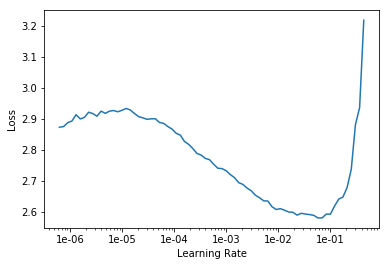

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(50, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.718402,1.822364,0.470908,00:19


Better model found at epoch 0 with accuracy value: 0.47090768814086914.


Exception in thread Thread-135:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 158, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 256, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/ubuntu/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87

KeyboardInterrupt: 

In [30]:
learn.callbacks = []
def TTA_score(load_pth='baseline'):
    learn.load(load_pth)
    preds = learn.TTA(ds_type=DatasetType.Test)
    test_preds = torch.argmax(preds[0], 1)
    test_preds = to_np(test_preds)
    test_labels = test_data.train_ds.y.items
    print(f"top1 acc: {np.mean(test_labels == test_preds)}")

def non_TTA_score(load_pth='baseline'):
    learn.load(load_pth)
    preds = learn.get_preds(ds_type=DatasetType.Test)
    test_preds = torch.argmax(preds[0], 1)
    test_preds = to_np(test_preds)
    test_labels = test_data.train_ds.y.items
    print(f"top1 acc: {np.mean(test_labels == test_preds)}")

In [32]:
non_TTA_score()

top1 acc: 0.91


In [31]:
TTA_score()

top1 acc: 0.922


### Bag of Tricks 

https://arxiv.org/pdf/1812.01187.pdf

#### 1. Large batch 

**Large Batch Size Training**

- Increase learning rate as lr x bs_new/bs_old

**Warmup with first m batches**

- Linearly increase learning rate to lr in first m batches 

**Set $\gamma$ = 0 in BN layers in ResBlocks**

- Mimics a network with less parameters at the beginning of training

**No wd (L2 reg) in bias, or BN params $\gamma, \beta$**

#### 2. Low Precision

**FP16 Training**

#### 3. ResNet Tweaks

ResNetB, ResNetC, ResNetD...

#### 4. Cosine Annealing LR

#### 5. Label Smoothing

LabelSmoothingCrossEntropy()

#### 6. Student Teacher

$(p,softmax(z)) + T^{2}(softmax(r/T),softmax(z/T))$

#### 7. Mixup Training